In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import seaborn as sns
from pybaseball import batting_stats

# personal function
import sys
sys.path.append("/Users/briandeng/Documents/func")
import plot, search
import importlib

In [2]:
def reload(func):
    importlib.reload(func)

In [3]:
# import data
df = pd.read_csv("cleaned_data.csv")
df = df.drop(columns=["Unnamed: 0"])

In [4]:
df.head()

,player_name,batter_name,pitch_type,description,plate_x,plate_z,sz_top,sz_bot,release_speed,release_spin_rate,...,strikes,pfx_x,pfx_z,stand,p_throws,release_extension,launch_speed,launch_angle,swing,norm_plate_z
0,"White, Mitch",avisaíl garcía,SL,blocked_ball,2.53,-0.66,3.30,1.73,88.8,2403,...,2,0.11,0.52,R,R,6.3,NaN,NaN,0,-1.522293
1,"White, Mitch",keston hiura,SL,swinging_strike,1.10,1.81,3.37,1.53,88.2,2388,...,1,0.29,0.66,R,R,6.3,NaN,NaN,1,0.152174
2,"White, Mitch",kolten wong,FF,foul,-0.60,3.30,3.18,1.47,94.1,2385,...,1,-0.33,1.46,L,R,6.2,75.5,31.0,1,1.070175
3,"White, Mitch",kolten wong,CU,ball,-0.41,3.85,3.11,1.42,81.4,2440,...,1,0.42,-1.23,L,R,6.1,NaN,NaN,0,1.437870
4,"Vesia, Alex",mario feliciano,FF,ball,-1.20,1.20,3.24,1.57,94.2,2446,...,2,0.65,1.81,R,L,6.7,NaN,NaN,0,-0.221557


In [5]:
# categorize different pitch types
PITCH_CAT = {
    'fastball': ['FF', 'SI', 'FC', 'FA'],
    'breaking': ['SL', 'CU', 'ST', 'SV', 'KC', 'SC', 'KN'],
    'offspeed': ['CH', 'FS', 'FO', 'CS', 'EP'],
    'pitchout': ['PO']
}

# mapping function
def map_pitch(pitch_type):
    for cat, types in PITCH_CAT.items():
        if pitch_type in types:
            return cat
    
    # if not exist
    return "NA"

# map to dataframe
df["pitch_cat"] = df["pitch_type"].apply(map_pitch)
df["pitch_cat"].value_counts()

fastball    580940
breaking    375252
offspeed    176693
pitchout       119
Name: pitch_cat, dtype: int64

In [6]:
# split into different categories
cat_dict = {}
for pitch_cat in PITCH_CAT.keys():
    cat_dict[pitch_cat] = df[df["pitch_cat"] == pitch_cat]

In [7]:
df.columns

Index(['player_name', 'batter_name', 'pitch_type', 'description', 'plate_x',
       'plate_z', 'sz_top', 'sz_bot', 'release_speed', 'release_spin_rate',
       'pitch_type.1', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'stand',
       'p_throws', 'release_extension', 'launch_speed', 'launch_angle',
       'swing', 'norm_plate_z', 'pitch_cat'],
      dtype='object')

In [8]:
# interested features
features = ["plate_x", "norm_plate_z", "release_speed", "release_spin_rate", "pfx_x", "pfx_z"]

In [9]:
# load test data
test_df = pd.read_csv("cleaned_test_data.csv")
test_df = test_df.drop(columns=["Unnamed: 0"])
test_df.head()

,player_name,batter_name,description,pitch_type,plate_x,plate_z,sz_top,sz_bot,release_speed,release_spin_rate,...,pfx_x,pfx_z,stand,p_throws,zone,release_extension,launch_speed,launch_angle,swing,norm_plate_z
0,"Sandlin, Nick",ozzie albies,swinging_strike,FS,0.12,1.46,3.26,1.55,86.4,1457,...,-0.93,-0.39,L,R,8,6.7,NaN,NaN,1,-0.052632
1,"Sandlin, Nick",ozzie albies,swinging_strike,FS,-0.09,1.28,3.26,1.55,86.3,1621,...,-1.01,-0.44,L,R,13,6.5,NaN,NaN,1,-0.157895
2,"Sandlin, Nick",ozzie albies,ball,SI,-1.18,2.97,3.26,1.61,92.2,2216,...,-1.34,0.04,L,R,11,6.7,NaN,NaN,0,0.824242
3,"Sandlin, Nick",ozzie albies,ball,FS,-1.17,2.00,3.35,1.66,85.7,1628,...,-0.74,-0.25,L,R,13,6.5,NaN,NaN,0,0.201183
4,"Sandlin, Nick",ozzie albies,ball,FS,-1.95,1.57,3.27,1.63,86.1,1580,...,-0.92,-0.40,L,R,13,6.5,NaN,NaN,0,-0.036585


In [10]:
# map pitch category
test_df["pitch_cat"] = test_df["pitch_type"].apply(map_pitch)
test_df["pitch_cat"].value_counts()

fastball    184974
breaking    124854
offspeed     60607
pitchout        54
Name: pitch_cat, dtype: int64

In [11]:
# compute contact quality for each pitch in test data
def compute_cq(pitch):
    """
    With given pitch, calculate its contact quality.
    """

    # check swing or not
    if pitch["swing"] == 0:
        cq = 0
        return cq

    # get description
    description = pitch["description"]

    if description in ["swinging_strike", "swinging_strike_blocked", "foul", "foul_tip", "foul_bunt", "missed_bunt",
                       "bunt_foul_pitch"]: # swing and miss or foul
        cq = 0
    else:
        # get values
        ev = pitch["launch_speed"] # exit velocity
        la = pitch["launch_angle"] # launch angle
        try:
            # compute scores
            ev_score = min(1, max(0, (ev - 70) / 28))
            la_score = max(0, 1 - abs(la - 20) / 20)

            # compute cq
            cq = ev_score * la_score
        except TypeError:
            cq = None

    return cq

In [12]:
# apply to dataframe
test_df["CQ"] = test_df.apply(compute_cq, axis=1)

In [13]:
# create test dictionary for each pitch category
test_dict = {}
for pitch_cat in PITCH_CAT.keys():
    test_dict[pitch_cat] = test_df[test_df["pitch_cat"] == pitch_cat]

In [20]:
# CELL 1: Compute & cache KNN swing probabilities for multiple k (run once)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import brier_score_loss
import numpy as np

# --- inputs you control ---
k_values = [10, 100, 200, 500]
cat_lst = ["fastball", "breaking", "offspeed"]
# expects: cat_dict, test_dict, features to already exist in your session

# --- outputs we'll cache for reuse ---
knn_results = {
    "per_k_probs": {},        # k -> np.array of predicted probs for all test pitches (league-wide)
    "per_k_ytrue": {},        # k -> np.array of true labels (league-wide)
    "brier": {},              # k -> float
    "league_pred_avg": {},    # k -> float
    "league_actual_avg": {},  # k -> float
}

print("=== Computing KNN league-wide swing probabilities for multiple k ===")
for k in k_values:
    print(f"\n--- k = {k} ---")
    swing_probs_all = []
    y_true_all = []
    
    for pitch_cat in cat_lst:
        print(f"  Processing category: {pitch_cat}")
        # training
        cat_df = cat_dict[pitch_cat]
        X_train = cat_df[features].values
        y_train = cat_df["swing"].values
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train)
        
        # neighbors
        knn = NearestNeighbors(n_neighbors=k, algorithm="auto")
        knn.fit(X_scaled)
        
        # test
        test_df = test_dict[pitch_cat]
        X_test = test_df[features].values
        X_test_scaled = scaler.transform(X_test)
        
        # query neighbors & estimate p(swing)
        _, idx = knn.kneighbors(X_test_scaled)
        swing_probs = np.mean(y_train[idx], axis=1)
        
        # collect league-wide
        swing_probs_all.append(swing_probs)
        y_true_all.append(test_df["swing"].values)
    
    # concat across categories
    swing_probs_all = np.concatenate(swing_probs_all)
    y_true_all = np.concatenate(y_true_all)
    
    # metrics
    brier = brier_score_loss(y_true_all, swing_probs_all)
    pred_avg = float(np.mean(swing_probs_all))
    actual_avg = float(np.mean(y_true_all))
    
    # cache
    knn_results["per_k_probs"][k] = swing_probs_all
    knn_results["per_k_ytrue"][k] = y_true_all
    knn_results["brier"][k] = brier
    knn_results["league_pred_avg"][k] = pred_avg
    knn_results["league_actual_avg"][k] = actual_avg
    
    print(f"  Brier: {brier:.4f} | Pred. league swing%: {pred_avg*100:.2f}% | Actual league swing%: {actual_avg*100:.2f}%")

print("\nDone. knn_results now holds league-wide arrays & metrics for all k.")


=== Computing KNN league-wide swing probabilities for multiple k ===

--- k = 10 ---
  Processing category: fastball
  Processing category: breaking
  Processing category: offspeed
  Brier: 0.1734 | Pred. league swing%: 31.68% | Actual league swing%: 29.82%

--- k = 100 ---
  Processing category: fastball
  Processing category: breaking
  Processing category: offspeed
  Brier: 0.1612 | Pred. league swing%: 32.38% | Actual league swing%: 29.82%

--- k = 200 ---
  Processing category: fastball
  Processing category: breaking
  Processing category: offspeed
  Brier: 0.1618 | Pred. league swing%: 32.64% | Actual league swing%: 29.82%

--- k = 500 ---
  Processing category: fastball
  Processing category: breaking
  Processing category: offspeed
  Brier: 0.1639 | Pred. league swing%: 33.01% | Actual league swing%: 29.82%

Done. knn_results now holds league-wide arrays & metrics for all k.


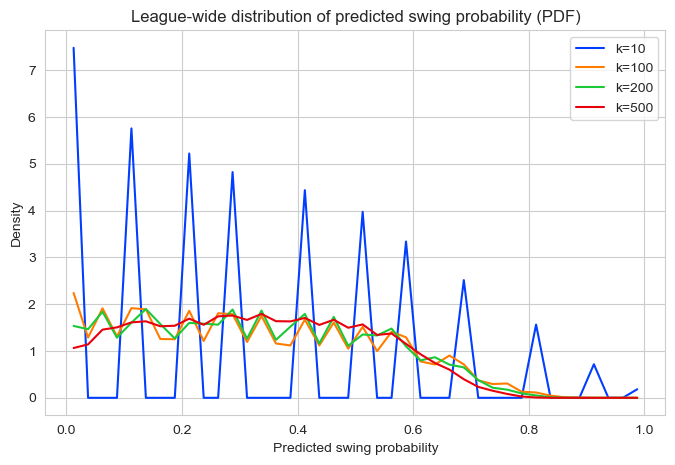

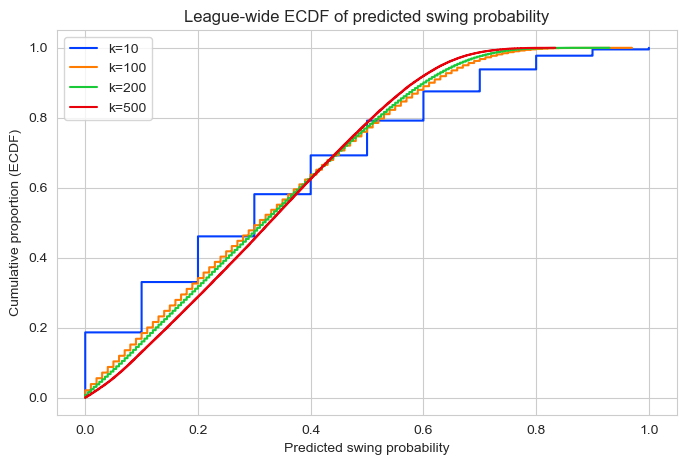

=== Summary (league-wide) ===
k | Brier | Pred swing% | Actual swing%
10 | 0.1734 |  31.68%   |  29.82%
100| 0.1612 |  32.38%   |  29.82%
200| 0.1618 |  32.64%   |  29.82%
500| 0.1639 |  33.01%   |  29.82%


In [21]:
# CELL 2: Visualize league-wide predicted swing probability distributions across k

import numpy as np
import matplotlib.pyplot as plt

# --- safety check ---
assert "knn_results" in globals(), "Run Cell 1 first to create `knn_results`."
k_values = sorted(knn_results["per_k_probs"].keys())

# --- A) PDF-style line histograms (same bins for fair comparison) ---
bins = np.linspace(0, 1, 41)  # 40 equal-width bins in [0, 1]
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(8, 5))
for k in k_values:
    probs = knn_results["per_k_probs"][k]
    hist, _ = np.histogram(probs, bins=bins, density=True)
    plt.plot(bin_centers, hist, marker='', linestyle='-', label=f'k={k}')
plt.xlabel("Predicted swing probability")
plt.ylabel("Density")
plt.title("League-wide distribution of predicted swing probability (PDF)")
plt.legend()
plt.grid(True)
plt.show()

# --- B) ECDFs (cumulative distribution comparison) ---
plt.figure(figsize=(8, 5))
for k in k_values:
    probs = np.sort(knn_results["per_k_probs"][k])
    y = np.arange(1, probs.size + 1) / probs.size
    plt.step(probs, y, where="post", label=f'k={k}')
plt.xlabel("Predicted swing probability")
plt.ylabel("Cumulative proportion (ECDF)")
plt.title("League-wide ECDF of predicted swing probability")
plt.legend()
plt.grid(True)
plt.show()

# --- Print metrics summary again ---
print("=== Summary (league-wide) ===")
print("k | Brier | Pred swing% | Actual swing%")
for k in k_values:
    print(f"{k:<3}| {knn_results['brier'][k]:.4f} | {knn_results['league_pred_avg'][k]*100:6.2f}%   | {knn_results['league_actual_avg'][k]*100:6.2f}%")


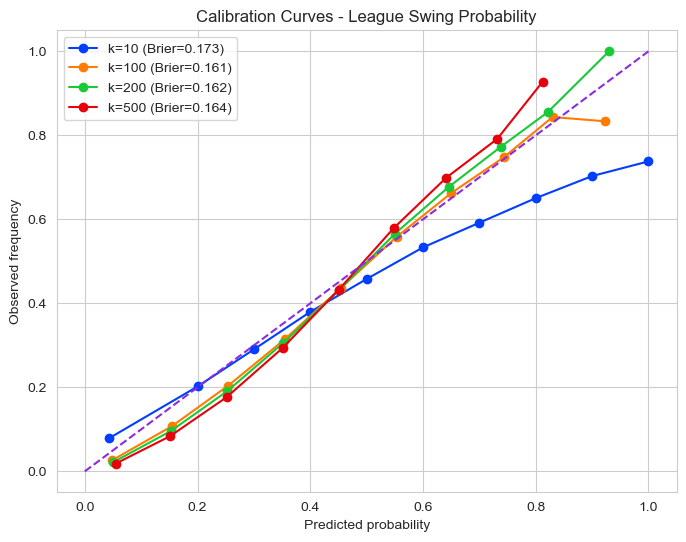

=== Calibration & Brier Summary (league-wide) ===
k | Brier | Pred swing% | Actual swing% | N
10 | 0.1734 |  31.68%   |  29.82%   | 370435
100| 0.1612 |  32.38%   |  29.82%   | 370435
200| 0.1618 |  32.64%   |  29.82%   | 370435
500| 0.1639 |  33.01%   |  29.82%   | 370435


In [22]:
# CELL 3: Calibration curves (reuse knn_results computed in Cell 1)

from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

assert "knn_results" in globals(), "Run Cell 1 first to create `knn_results`."
k_values = sorted(knn_results["per_k_probs"].keys())

# --- Calibration plot ---
plt.figure(figsize=(8, 6))

for k in k_values:
    y_true = knn_results["per_k_ytrue"][k]
    y_prob = knn_results["per_k_probs"][k]
    brier = knn_results["brier"][k]

    # reliability diagram (equal-width bins in [0,1])
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'k={k} (Brier={brier:.3f})')

# perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves - League Swing Probability")
plt.legend()
plt.grid(True)
plt.show()

# --- Print summary again ---
print("=== Calibration & Brier Summary (league-wide) ===")
print("k | Brier | Pred swing% | Actual swing% | N")
for k in k_values:
    y_true = knn_results["per_k_ytrue"][k]
    y_prob = knn_results["per_k_probs"][k]
    print(f"{k:<3}| {knn_results['brier'][k]:.4f} | {knn_results['league_pred_avg'][k]*100:6.2f}%   | {knn_results['league_actual_avg'][k]*100:6.2f}%   | {y_true.size}")


In [23]:
# use KNN method with choice of k neighbors
k = 200
result_dict = {}
cat_lst = ["fastball", "breaking", "offspeed"]
for pitch_cat in cat_lst:
    print(f"Clustering {pitch_cat}")
    # extract dataframe and values
    cat_df = cat_dict[pitch_cat]
    X_train = cat_df[features].values
    y_train = cat_df["swing"].values

    # normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # fit KNN model
    print("Fitting starts")
    KNN = NearestNeighbors(n_neighbors=k, algorithm="auto")
    KNN.fit(X_scaled)
    print("Fitting ends")

    # estimate swinging probability
    test_df = test_dict[pitch_cat]
    # extract data
    X_test = test_df[features].values
    # normalize test data
    X_test_scaled = scaler.transform(X_test)

    # find k nearest
    print("Fitting test pitches")
    distances, indices = KNN.kneighbors(X_test_scaled)

    # compute prob
    swing_probs = np.mean(y_train[indices], axis=1)

    # add to data frame
    result_df = test_df[["player_name", "batter_name", "pitch_cat", "swing", "CQ"]]
    result_df["PS"] = swing_probs

    # add to dictionary
    result_dict[pitch_cat] = result_df
    print(f"{pitch_cat} finished")
    # break

Clustering fastball
Fitting starts
Fitting ends
Fitting test pitches


/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/3335435514.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["PS"] = swing_probs


fastball finished
Clustering breaking
Fitting starts
Fitting ends
Fitting test pitches


/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/3335435514.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["PS"] = swing_probs


breaking finished
Clustering offspeed
Fitting starts
Fitting ends
Fitting test pitches
offspeed finished


/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/3335435514.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["PS"] = swing_probs


In [24]:
# combine all pitch categories dataframe to one
result_df = pd.concat([result_dict["fastball"], result_dict["breaking"], result_dict["offspeed"]], ignore_index=True)

In [25]:
# define DS
def DS(pitch):
    """
    Compute discipline score.
    """

    # get values
    r = pitch["swing"] # actual result
    ps = pitch["PS"] # predict result

    # compute ds
    ds = (-1)**r * (r * (1 - ps) + (1 - r) * ps)

    return ds

# apply to dataframe
result_df["DS"] = result_df.apply(DS, axis=1)

# compute ADS
result_df["ADS"] = result_df["DS"] + result_df["CQ"]

In [26]:
# apply DS and ADS to result_dict
for pitch_cat in cat_lst:
    # get dataframe
    cat_df = result_dict[pitch_cat]
    # compute DS
    cat_df["DS"] = cat_df.apply(DS, axis=1)
    # compute ADS
    cat_df["ADS"] = cat_df["DS"] + cat_df["CQ"]

/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/1459506182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df["DS"] = cat_df.apply(DS, axis=1)
/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/1459506182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df["ADS"] = cat_df["DS"] + cat_df["CQ"]
/var/folders/fy/8vyj44fn6fx3dtcpxwrnxt9w0000gn/T/ipykernel_49036/1459506182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [27]:
result_df.head()

,player_name,batter_name,pitch_cat,swing,CQ,PS,DS,ADS
0,"Sandlin, Nick",ozzie albies,fastball,0,0.0,0.405,0.405,0.405
1,"Sandlin, Nick",ronald acuña,fastball,0,0.0,0.080,0.080,0.080
2,"Sandlin, Nick",ronald acuña,fastball,0,0.0,0.175,0.175,0.175
3,"Lee, Dylan",andrés giménez,fastball,0,0.0,0.135,0.135,0.135
4,"Lee, Dylan",david fry,fastball,1,0.0,0.325,-0.675,-0.675


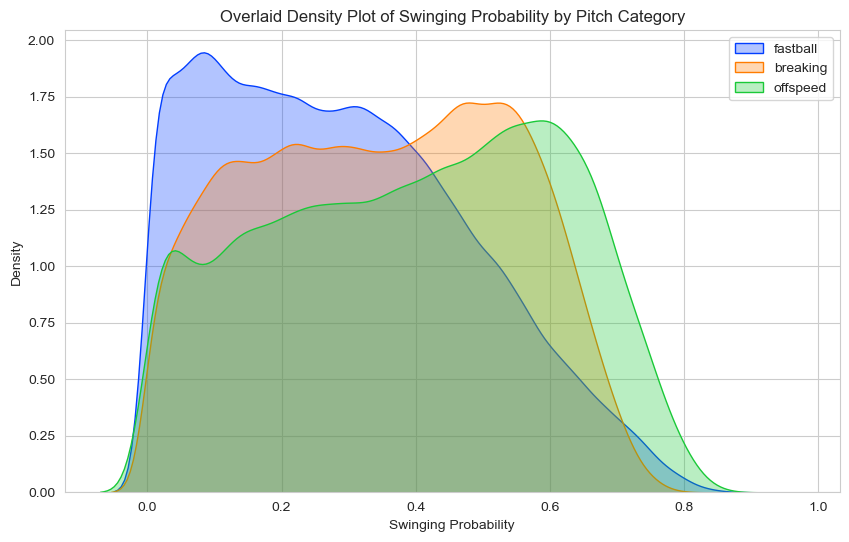

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for pitch_cat in cat_lst:
    sns.kdeplot(
        data=result_dict[pitch_cat],
        x="PS",
        label=pitch_cat,
        fill=True,       # fill under the curve
        alpha=0.3,       # transparency for fill
        bw_adjust=1.0    # smoothing factor
    )

plt.xlabel("Swinging Probability")
plt.ylabel("Density")
plt.title("Overlaid Density Plot of Swinging Probability by Pitch Category")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# compute best PS for pitcher
reload(search)
for pitch_cat in cat_lst:
    print(pitch_cat)
    # get dataframe and feature columns
    pitcher_df = result_dict[pitch_cat][["player_name", "PS"]]
    # filter pitcher at least 75% appearance
    pitcher_df = search.filter_data(pitcher_df, 0.9, "player_name", info=True)
    # group by pitcher
    pitcher_df = pitcher_df.groupby("player_name").mean()
    # rank top 10 pitchers
    pitcher_df = search.rank(pitcher_df, by="PS", ascending=False)
    # save to csv file
    pitcher_df.to_csv(f"{pitch_cat}_pitcher.csv")

fastball
max = 1043, min = 1, threshold = 560.0
breaking
max = 1065, min = 1, threshold = 362.5
offspeed
max = 729, min = 1, threshold = 251.0


In [31]:
# group batter
group_dict = {}
for pitch_cat in cat_lst:
    # get result dataframe
    cat_result_df = result_dict[pitch_cat][["batter_name", "PS", "CQ", "DS", "ADS"]]
    # group by batter name
    group_df = cat_result_df.groupby("batter_name").mean()
    group_df["batter_name"] = group_df.index
    # update to dictionary
    group_dict[pitch_cat] = group_df

# group batter for all categories
group_result_df = result_df[["batter_name", "PS", "CQ", "DS", "ADS"]].groupby("batter_name").mean()
group_result_df["batter_name"] = group_result_df.index

In [32]:
# get top 10 DS for each category with at least 75% appearance
for pitch_cat in cat_lst:
    print(pitch_cat)
    # get dataframe and feature columns
    batter_df = result_dict[pitch_cat][["batter_name", "DS"]]
    # filter pitcher at least 75% appearance
    batter_df = search.filter_data(batter_df, 0.75, "batter_name", info=True)
    # group by pitcher
    batter_df = batter_df.groupby("batter_name").mean()
    # rank top 10 pitchers
    batter_df = search.rank(batter_df, by="DS", ascending=False)
    # save to csv file
    batter_df.to_csv(f"{pitch_cat}_DS_batter.csv")

fastball
max = 861, min = 1, threshold = 460.0
breaking
max = 625, min = 1, threshold = 300.5
offspeed
max = 413, min = 1, threshold = 147.0


In [51]:
def compare_players(players, cats=None):
    """
    Plot PS, DS, CQ, and ADS for given players across pitch categories.
    - Subplots: one for each category (default: fastball, breaking, offspeed)
    - Legend shown in each subplot
    Expects: group_dict, cat_lst, and search.search_column_value available.
    """
    if cats is None:
        cats = ["fastball", "breaking", "offspeed"]

    metrics_labels = ["PS", "DS", "CQ", "ADS"]
    players_order = list(players)

    # 1 x len(cats) subplots
    fig, axes = plt.subplots(1, len(cats), figsize=(18, 6), sharey=True)

    # if only one category, axes is a single Axes; wrap it
    if len(cats) == 1:
        axes = [axes]

    for i, pitch_cat in enumerate(cats):
        local_df = group_dict[pitch_cat]
        local_df = local_df[local_df["batter_name"].isin(players_order)]

        # build long dataframe: one row per (player, metric)
        records = []
        for player in players_order:
            vals = search.search_column_value(local_df, "batter_name", metrics_labels, player)
            vals = np.asarray(vals).ravel().tolist()
            vals = [float(v) for v in vals]
            for m, v in zip(metrics_labels, vals):
                records.append({"player": player, "metrics": m, "values": v})

        plot_df = pd.DataFrame.from_records(records)
        plot_df["player"]  = pd.Categorical(plot_df["player"],  categories=players_order,  ordered=True)
        plot_df["metrics"] = pd.Categorical(plot_df["metrics"], categories=metrics_labels, ordered=True)

        ax = axes[i]
        sns.barplot(
            data=plot_df,
            x="metrics",
            y="values",
            hue="player",
            errorbar=None,
            ax=ax
        )

        ax.set_title(pitch_cat)
        ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel("Value")
        else:
            ax.set_ylabel("")
        ax.tick_params(axis="x", rotation=0)
        ax.legend(title="Player", loc="best", frameon=False)  # keep legend on each subplot

    plt.tight_layout()
    plt.show()


In [34]:
# get 2024 batting stats
df_2024_batting = batting_stats(2024)
df_2024_batting["Name"] = df_2024_batting["Name"].str.lower() # change to lower
# combine with result dataframe
df2 = group_result_df
df2["Name"] = df2["batter_name"]
# change specific name
df_2024_batting.loc[df_2024_batting["Name"] == "vladimir guerrero jr.", "Name"] = "vladimir guerrero"
df_2024 = pd.merge(df_2024_batting, df2, on="Name")

In [35]:
def search_players(players, metrics):
    """
    Print out given players and metrics value.
    """

    for player in players:
        # get player df
        p_df = df_2024[df_2024["Name"] == player]
        # get interested metrics
        p_df = p_df[["Name"] + metrics]
        # print out information
        print(p_df)

In [78]:
search.rank(data=df_2024, by="DS", ascending=False, features=["Name", "O-Swing%", "PA", "BB/K", "BB%", "K%", "DS"], num=20)

,Name,O-Swing%,PA,BB/K,BB%,K%,DS
0,aaron judge,0.213,704,0.78,0.189,0.243,0.145109
102,andrew mccutchen,0.216,515,0.44,0.113,0.258,0.143778
57,jonathan india,0.213,637,0.64,0.126,0.196,0.135854
90,jesse winker,0.229,508,0.59,0.124,0.209,0.133356
2,juan soto,0.213,713,1.08,0.181,0.167,0.118856
25,steven kwan,0.222,540,1.04,0.098,0.094,0.110881
61,taylor ward,0.233,663,0.39,0.095,0.246,0.099923
36,seiya suzuki,0.236,585,0.39,0.108,0.274,0.098300
41,kyle schwarber,0.240,692,0.54,0.153,0.285,0.097229
92,george springer,0.284,614,0.52,0.098,0.187,0.094107


In [53]:
players = ["juan soto", "aaron judge", "mookie betts"]
search_players(players, ["O-Swing%", "PA", "BB", "BB%", "K%", "OBP", "AVG", "DS", "ADS", "CQ"])

        Name  O-Swing%   PA   BB    BB%     K%    OBP    AVG        DS  \
2  juan soto     0.213  713  129  0.181  0.167  0.419  0.288  0.118856   

        ADS        CQ  
2  0.128027  0.009171  
          Name  O-Swing%   PA   BB    BB%     K%    OBP    AVG        DS  \
0  aaron judge     0.213  704  133  0.189  0.243  0.458  0.322  0.145109   

        ADS        CQ  
0  0.151181  0.006071  
            Name  O-Swing%   PA  BB    BB%    K%    OBP    AVG        DS  \
18  mookie betts     0.229  516  61  0.118  0.11  0.372  0.289  0.084912   

         ADS        CQ  
18  0.104049  0.019138  


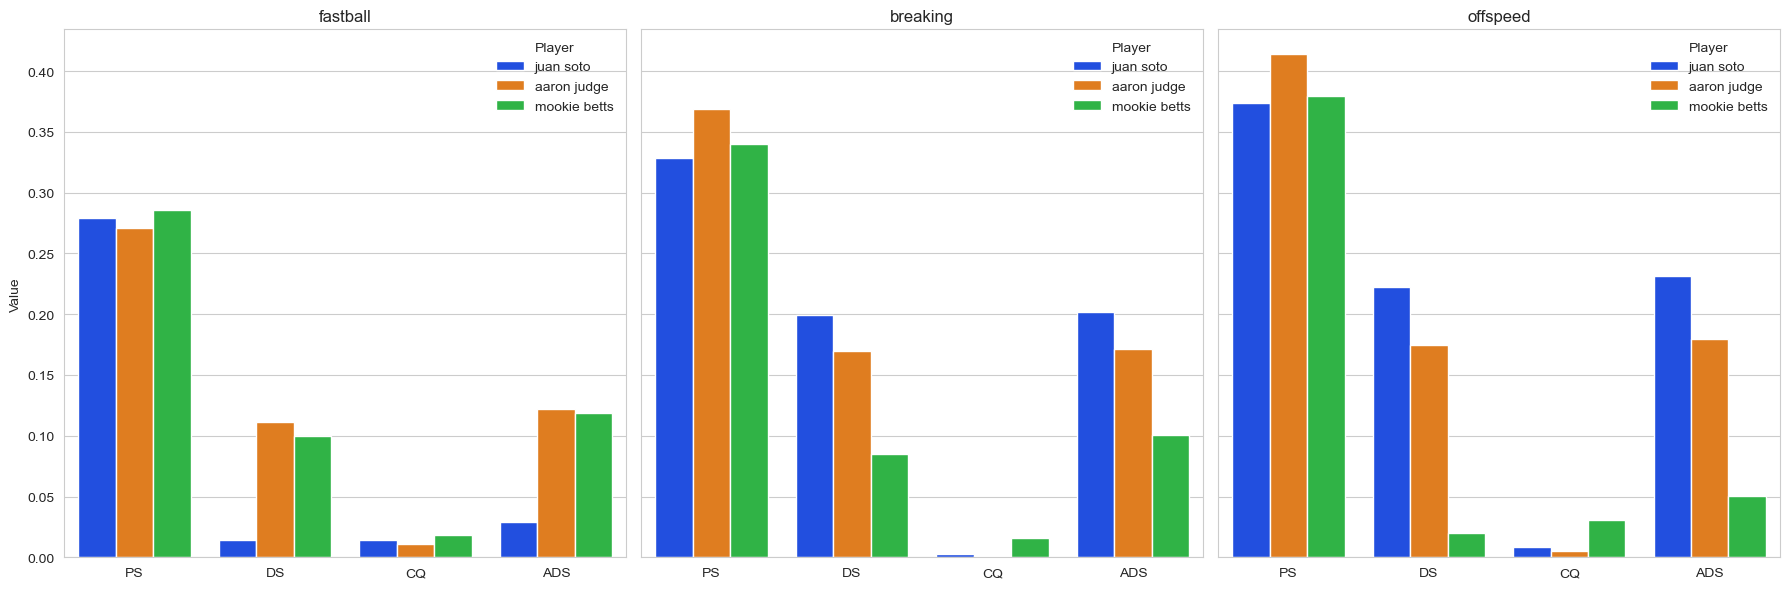

In [52]:
compare_players(players)

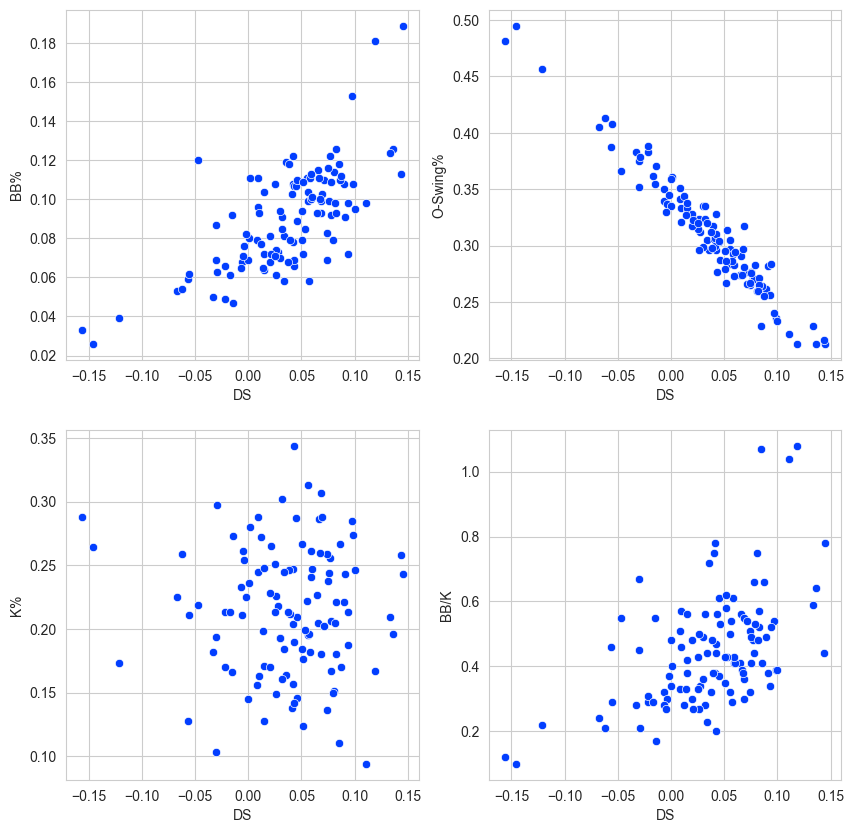

In [92]:
# plot DS relation with related metrics
f_lst = ["BB%", "K%", "O-Swing%", "BB/K"]

# create a 2*2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# initial x, y
x, y = 0, 0

for i in range(4):
    # get feature
    feature = f_lst[i]

    # plot graph
    sns.scatterplot(data=df_2024, x="DS", y=feature, ax=axes[x, y])

    # update x, y
    if x == 0 and y == 0:
        x = 1
    elif x == 1 and y == 0:
        x = 0
        y = 1
    elif x == 0 and y == 1:
        x = 1

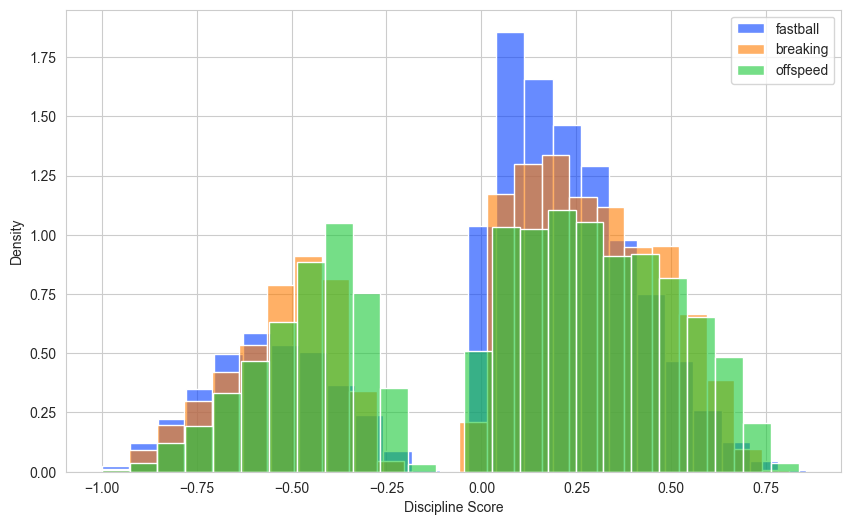

In [115]:
# plot distributions of discipline score of all categories
plt.figure(figsize=(10, 6))
for pitch_cat in cat_lst:
    sns.histplot(data=result_dict[pitch_cat], x="DS", bins=25, stat="density", label=pitch_cat, alpha=0.6)
# sns.histplot(data=group_result_df, x="DS", bins=15, stat="density", label="all categories", alpha=0.6)
plt.xlabel("Discipline Score")
plt.legend()
plt.show()

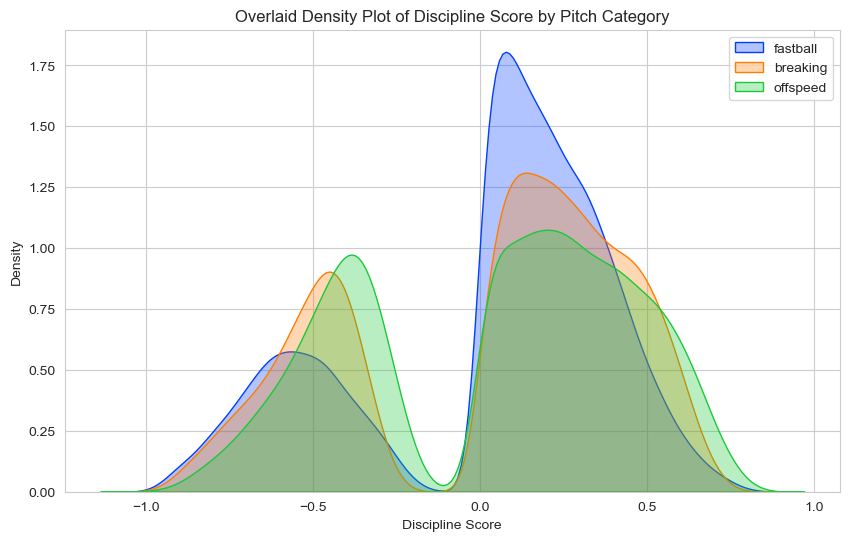

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for pitch_cat in cat_lst:
    sns.kdeplot(
        data=result_dict[pitch_cat],
        x="DS",
        label=pitch_cat,
        fill=True,    # fill under the curve
        alpha=0.3,    # transparency for overlap
        bw_adjust=1.0 # smoothing factor
    )

plt.xlabel("Discipline Score")
plt.ylabel("Density")
plt.title("Overlaid Density Plot of Discipline Score by Pitch Category")
plt.legend()
plt.grid(True)
plt.show()
